
# 01 – EDA and Preprocessing (Beginner Friendly)

This notebook takes you from **zero** to a **model-ready dataset** step-by-step.
You can **run each cell in order** (Shift + Enter). Explanations are written in plain language.


In [17]:

# 1) Imports – these are the only libraries we need
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

pd.set_option("display.max_columns", 100)



## 2) Load the dataset

- We already copied your Excel file into `data/raw/`.
- If loading fails, check that the file exists and the name matches.


In [18]:
def split_and_expand(df_in, col):
    from collections import defaultdict
    import pandas as pd

    rows = []
    items = set()
    for idx, val in df_in[col].items():
        for item in str(val).split(","):
            item = item.strip()
            if item:
                rows.append((idx, item))
                items.add(item)

    expanded = pd.DataFrame(0, index=df_in.index, columns=[f"{col}__{item}" for item in items])
    for idx, item in rows:
        expanded.at[idx, f"{col}__{item}"] = 1

    return pd.concat([df_in, expanded], axis=1)

data_path = r"C:\Users\Default.DESKTOP-IT4P83D\Desktop\Pusula_DS_Starter\data\raw\Talent_Academy_Case_DT_2025.xlsx"
assert os.path.exists(data_path), f"Dataset not found at: {data_path}"
df = pd.read_excel(data_path)  # requires 'openpyxl'
print(df.shape)
df.head()


(2235, 13)


,HastaNo,Yas,Cinsiyet,KanGrubu,Uyruk,KronikHastalik,Bolum,Alerji,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi
0,145134,60,Kadın,0 Rh+,Türkiye,"Becker Musküler Distrofisi, Hiportiroidizm, Ka...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",TOZ,Ayak bileği ve ayağın yüzeysel yaralanması,Ayak Bileği,5 Seans,Ayak Bileği,20 Dakika
1,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,20 Dakika
2,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika
3,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,5 Dakika
4,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika



## 3) Understand the columns quickly
- `info()` shows column names and detected data types.
- `isna().sum()` counts missing values per column.


In [19]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   HastaNo          2235 non-null   int64 
 1   Yas              2235 non-null   int64 
 2   Cinsiyet         2066 non-null   object
 3   KanGrubu         1560 non-null   object
 4   Uyruk            2235 non-null   object
 5   KronikHastalik   1624 non-null   object
 6   Bolum            2224 non-null   object
 7   Alerji           1291 non-null   object
 8   Tanilar          2160 non-null   object
 9   TedaviAdi        2235 non-null   object
 10  TedaviSuresi     2235 non-null   object
 11  UygulamaYerleri  2014 non-null   object
 12  UygulamaSuresi   2235 non-null   object
dtypes: int64(2), object(11)
memory usage: 227.1+ KB


In [20]:

df.isna().sum().sort_values(ascending=False)


Alerji             944
KanGrubu           675
KronikHastalik     611
UygulamaYerleri    221
Cinsiyet           169
Tanilar             75
Bolum               11
HastaNo              0
Yas                  0
Uyruk                0
TedaviAdi            0
TedaviSuresi         0
UygulamaSuresi       0
dtype: int64


## 4) Clean up obvious text issues
- Strip leading/trailing spaces from text.
- Standardize commas (in list-like columns) and replace multiple spaces.


In [21]:

df.columns = [c.strip() for c in df.columns]

def clean_text(x):
    if pd.isna(x):
        return x
    x = str(x).strip()
    x = re.sub(r"\s*,\s*", ",", x)
    x = re.sub(r"\s+", " ", x)
    return x

text_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in text_cols:
    df[c] = df[c].apply(clean_text)

df.head(3)


,HastaNo,Yas,Cinsiyet,KanGrubu,Uyruk,KronikHastalik,Bolum,Alerji,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi
0,145134,60,Kadın,0 Rh+,Türkiye,"Becker Musküler Distrofisi,Hiportiroidizm,Kalp...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",TOZ,Ayak bileği ve ayağın yüzeysel yaralanması,Ayak Bileği,5 Seans,Ayak Bileği,20 Dakika
1,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi,Myastenia gravis,...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ,DİĞER,SERVİKOTO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,20 Dakika
2,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi,Myastenia gravis,...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ,DİĞER,SERVİKOTO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika



## 5) Split columns by type

We'll identify:
- **Target**: `TedaviSuresi`
- **Numeric** columns (e.g., `Yas`, `UygulamaSuresi` if present)
- **Categorical (single-choice)** columns (e.g., `Cinsiyet`, `KanGrubu`, `Uyruk`, `Bolum`, `TedaviAdi`)
- **List (multi-choice)** columns that contain comma-separated items (e.g., `KronikHastalik`, `Alerji`, `Tanilar`, `UygulamaYerleri`)


In [22]:

target_col = "TedaviSuresi"

numeric_cols = []
for c in df.columns:
    if c == target_col:
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        numeric_cols.append(c)

possible_cats = ["Cinsiyet", "KanGrubu", "Uyruk", "Bolum", "TedaviAdi"]
single_cat_cols = [c for c in possible_cats if c in df.columns]

list_like_cols = [c for c in ["KronikHastalik", "Alerji", "Tanilar", "UygulamaYerleri"] if c in df.columns]

numeric_cols, single_cat_cols, list_like_cols


(['HastaNo', 'Yas'],
 ['Cinsiyet', 'KanGrubu', 'Uyruk', 'Bolum', 'TedaviAdi'],
 ['KronikHastalik', 'Alerji', 'Tanilar', 'UygulamaYerleri'])


## 6) Quick plots (matplotlib only)

We'll look at simple histograms for numeric columns and the target distribution.


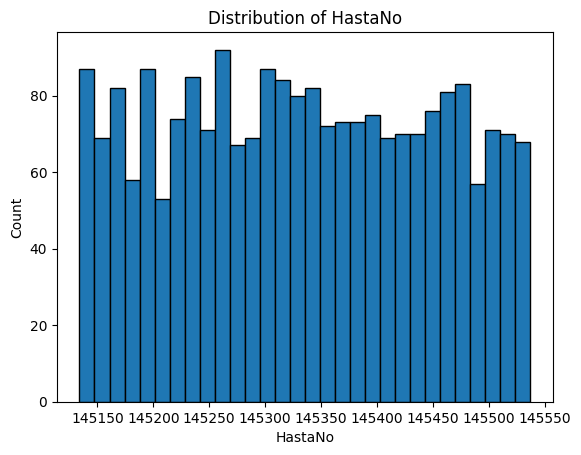

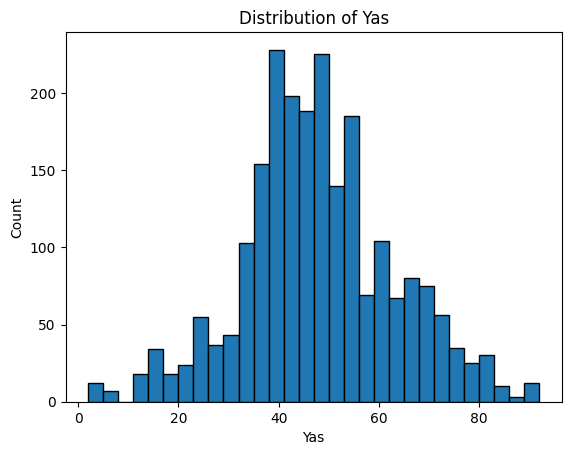

In [23]:

if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]):
    plt.figure()
    df[target_col].dropna().plot(kind="hist", bins=30, edgecolor="black")
    plt.title("Distribution of TedaviSuresi")
    plt.xlabel("TedaviSuresi")
    plt.ylabel("Count")
    plt.show()

for c in numeric_cols:
    plt.figure()
    df[c].dropna().plot(kind="hist", bins=30, edgecolor="black")
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()



## 7) Explore list-like columns

These columns contain comma-separated values. We'll split them and count the most common items.


In [24]:

from collections import Counter

def split_to_list(val):
    if pd.isna(val) or str(val).strip() == "":
        return []
    return [x.strip() for x in str(val).split(",") if x.strip() != ""]

for c in list_like_cols:
    counts = Counter()
    for v in df[c].dropna():
        counts.update(split_to_list(v))
    print(f"\nTop 15 for {c}:")
    for item, cnt in counts.most_common(15):
        print(f"  {item}: {cnt}")



Top 15 for KronikHastalik:
  Aritmi: 395
  Hiportiroidizm: 383
  Limb-Girdle Musküler Distrofi: 379
  Astım: 351
  Hipertiroidizm: 327
  Myastenia gravis: 316
  Diyabet: 308
  Duchenne Musküler Distrofisi: 307
  Fascioscapulohumeral Distrofi: 304
  Kalp yetmezliği: 301
  Hipertansiyon: 285
  Polimiyozit: 275
  Becker Musküler Distrofisi: 243
  Guatr: 3
  Hipotirodizm: 3

Top 15 for Alerji:
  Polen: 330
  POLEN: 170
  Toz: 138
  TOZ: 121
  NOVALGIN: 110
  ARVELES: 102
  CORASPIN: 102
  Sucuk: 96
  Yer Fıstığı: 83
  SUCUK: 78
  Novalgin: 72
  GRİPİN: 55
  VOLTAREN: 45
  Voltaren: 41
  Volteren: 35

Top 15 for Tanilar:
  DORSALJİ: 695
  DİĞER: 676
  tanımlanmamış: 408
  Omuzun darbe sendromu: 272
  İntervertebral disk bozuklukları: 269
  LUMBOSAKRAL BÖLGE: 265
  SERVİKOTORASİK BÖLGE: 211
  SERVİKAL BÖLGE: 148
  Eklem ağrısı: 113
  Dorsalji: 105
  diğer: 92
  Fibromiyalji: 70
  Menisküs yırtığı: 62
  şimdiki: 62
  Ekstremite ağrısı: 61

Top 15 for UygulamaYerleri:
  Bel: 543
  Boyun: 388



## 8) Turn list-like columns into multi-hot features

We'll create new columns like `Alerji__Penisilin = 1/0` for each unique item that appears at least a few times.


In [25]:

import pandas as pd

def make_multihot(df_in, col, min_count=5):

    s = df_in[col].dropna().apply(split_to_list)

    exploded = s.explode()
    exploded = exploded.astype(str).str.strip()
    exploded = exploded[exploded != ""]

    vc = exploded.value_counts()
    keep = vc[vc >= min_count].index

    exploded = exploded[exploded.isin(keep)]
    if exploded.empty:
        return df_in.copy()
    
    mat = pd.crosstab(exploded.index, exploded)

    mat.columns = [f"{col}__{c}" for c in mat.columns]
    out = df_in.join(mat, how="left")

    out.loc[:, mat.columns] = out.loc[:, mat.columns].fillna(0).astype(int)
    return out


df_multi = df.copy()
for c in list_like_cols:
    df_multi = make_multihot(df_multi, c, min_count=5)

df_multi = df_multi.drop(columns=list_like_cols)
df_multi.head(3)


,HastaNo,Yas,Cinsiyet,KanGrubu,Uyruk,Bolum,TedaviAdi,TedaviSuresi,UygulamaSuresi,KronikHastalik__Aritmi,KronikHastalik__Astım,KronikHastalik__Becker Musküler Distrofisi,KronikHastalik__Diyabet,KronikHastalik__Duchenne Musküler Distrofisi,KronikHastalik__Fascioscapulohumeral Distrofi,KronikHastalik__Hipertansiyon,KronikHastalik__Hipertiroidizm,KronikHastalik__Hiportiroidizm,KronikHastalik__Kalp yetmezliği,KronikHastalik__Limb-Girdle Musküler Distrofi,KronikHastalik__Myastenia gravis,KronikHastalik__Polimiyozit,Alerji__ARVELES,Alerji__CORASPIN,Alerji__GRIPIN,Alerji__GRİPİN,Alerji__NOVALGIN,Alerji__Novalgin,Alerji__POLEN,Alerji__Polen,Alerji__SUCUK,Alerji__Sucuk,Alerji__TOZ,Alerji__Toz,Alerji__VOLTAREN,Alerji__Voltaren,Alerji__Volteren,Alerji__Yer Fıstığı,Tanilar__ARTİKÜLER KIKIRDAK DİĞER BOZUKLUKLARI,Tanilar__Akut apandisit,Tanilar__Algonörodistrofi,Tanilar__Allerjik rinit,Tanilar__Alt ekstremite mononöropatileri,Tanilar__Artroz,Tanilar__Astım,Tanilar__Aterosklerotik kardiyovasküler hastalık,Tanilar__Atrial fibrilasyon ve flutter,Tanilar__Ayak bileği ve ayak düzeyinde eklem ve ligamentlerin çıkık,Tanilar__Ayak bileği ve ayak düzeyinde kas ve tendon yaralanması,Tanilar__Ayak bileği ve ayağın diğer ve tanımlanmamış yaralanmaları,...,Tanilar__Vitamin D eksikliği,Tanilar__ayak bileği hariç,Tanilar__ayak bileği ve ayak,Tanilar__bacak,Tanilar__başka yerde sınıflanmamış,Tanilar__başka yerde sınıflanmış hastalıklarda,Tanilar__bilateral,Tanilar__birden fazla yer,Tanilar__burkulma ve gerilmesi,Tanilar__diğer,Tanilar__diğer radikulopati ile,Tanilar__diğer sendromları,Tanilar__el,Tanilar__eski yırtık veya yaralanmaya bağlı,Tanilar__kapalı,Tanilar__kol,Tanilar__myelopati ile (G99.2*),Tanilar__patolojik kırıksız,Tanilar__pelvik bölge ve kalça,Tanilar__peritoneal apse ile,Tanilar__tanımlanmamış,Tanilar__tanımlanmamış organizmalar,Tanilar__tanımlanmış,Tanilar__yeri tanımlanmamış,Tanilar__İliotibial band sendromu,Tanilar__İntervertebral disk bozuklukları,Tanilar__şimdiki,UygulamaYerleri__Ayak Bileği,UygulamaYerleri__Bel,UygulamaYerleri__Boyun,UygulamaYerleri__Dirsek,UygulamaYerleri__Diz,UygulamaYerleri__El Bilek,UygulamaYerleri__Kalça,UygulamaYerleri__Omuz,UygulamaYerleri__Sağ Ayak Bileği Bölgesi,UygulamaYerleri__Sağ Dirsek Bölgesi,UygulamaYerleri__Sağ Diz Bölgesi,UygulamaYerleri__Sağ El Bilek Bölgesi,UygulamaYerleri__Sağ Kalça Bölgesi,UygulamaYerleri__Sağ Omuz Bölgesi,UygulamaYerleri__Sol Ayak Bileği Bölgesi,UygulamaYerleri__Sol Dirsek Bölgesi,UygulamaYerleri__Sol Diz Bölgesi,UygulamaYerleri__Sol El Bilek Bölgesi,UygulamaYerleri__Sol Kalça Bölgesi,UygulamaYerleri__Sol Omuz Bölgesi,UygulamaYerleri__Sırt,UygulamaYerleri__Tüm Vücut Bölgesi,UygulamaYerleri__Yüz
0,145134,60,Kadın,0 Rh+,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",Ayak Bileği,5 Seans,20 Dakika,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,145135,28,Erkek,0 Rh+,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",Dorsalji -Boyun+trapez+skapular,15 Seans,20 Dakika,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,145135,28,Erkek,0 Rh+,Türkiye,"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",Dorsalji -Boyun+trapez+skapular,15 Seans,20 Dakika,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## 9) Prepare final feature groups


In [26]:

final_numeric = [c for c in df_multi.columns if pd.api.types.is_numeric_dtype(df_multi[c]) and c != target_col]
final_cats = [c for c in single_cat_cols if c in df_multi.columns]
print("Numeric (final):", final_numeric)
print("Categorical (single-choice):", final_cats)


Numeric (final): ['HastaNo', 'Yas', 'KronikHastalik__Aritmi', 'KronikHastalik__Astım', 'KronikHastalik__Becker Musküler Distrofisi', 'KronikHastalik__Diyabet', 'KronikHastalik__Duchenne Musküler Distrofisi', 'KronikHastalik__Fascioscapulohumeral Distrofi', 'KronikHastalik__Hipertansiyon', 'KronikHastalik__Hipertiroidizm', 'KronikHastalik__Hiportiroidizm', 'KronikHastalik__Kalp yetmezliği', 'KronikHastalik__Limb-Girdle Musküler Distrofi', 'KronikHastalik__Myastenia gravis', 'KronikHastalik__Polimiyozit', 'Alerji__ARVELES', 'Alerji__CORASPIN', 'Alerji__GRIPIN', 'Alerji__GRİPİN', 'Alerji__NOVALGIN', 'Alerji__Novalgin', 'Alerji__POLEN', 'Alerji__Polen', 'Alerji__SUCUK', 'Alerji__Sucuk', 'Alerji__TOZ', 'Alerji__Toz', 'Alerji__VOLTAREN', 'Alerji__Voltaren', 'Alerji__Volteren', 'Alerji__Yer Fıstığı', 'Tanilar__ARTİKÜLER KIKIRDAK DİĞER BOZUKLUKLARI', 'Tanilar__Akut apandisit', 'Tanilar__Algonörodistrofi', 'Tanilar__Allerjik rinit', 'Tanilar__Alt ekstremite mononöropatileri', 'Tanilar__Artroz',


## 10) Build a scikit-learn preprocessing pipeline


In [27]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

X = df_multi.drop(columns=[target_col]) if target_col in df_multi.columns else df_multi.copy()
y = df_multi[target_col] if target_col in df_multi.columns else None

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, final_numeric),
        ("cat", categorical_transformer, final_cats)
    ],
    remainder="drop"
)

X_processed = preprocessor.fit_transform(X)

num_feats = final_numeric
cat_feats = []
if final_cats:
    cat_feats = list(preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(final_cats))

processed_columns = num_feats + cat_feats
import pandas as pd
X_processed_df = pd.DataFrame(X_processed, columns=processed_columns, index=df_multi.index)

print("Processed shape:", X_processed_df.shape)
X_processed_df.head()


Processed shape: (2235, 468)


,HastaNo,Yas,KronikHastalik__Aritmi,KronikHastalik__Astım,KronikHastalik__Becker Musküler Distrofisi,KronikHastalik__Diyabet,KronikHastalik__Duchenne Musküler Distrofisi,KronikHastalik__Fascioscapulohumeral Distrofi,KronikHastalik__Hipertansiyon,KronikHastalik__Hipertiroidizm,KronikHastalik__Hiportiroidizm,KronikHastalik__Kalp yetmezliği,KronikHastalik__Limb-Girdle Musküler Distrofi,KronikHastalik__Myastenia gravis,KronikHastalik__Polimiyozit,Alerji__ARVELES,Alerji__CORASPIN,Alerji__GRIPIN,Alerji__GRİPİN,Alerji__NOVALGIN,Alerji__Novalgin,Alerji__POLEN,Alerji__Polen,Alerji__SUCUK,Alerji__Sucuk,Alerji__TOZ,Alerji__Toz,Alerji__VOLTAREN,Alerji__Voltaren,Alerji__Volteren,Alerji__Yer Fıstığı,Tanilar__ARTİKÜLER KIKIRDAK DİĞER BOZUKLUKLARI,Tanilar__Akut apandisit,Tanilar__Algonörodistrofi,Tanilar__Allerjik rinit,Tanilar__Alt ekstremite mononöropatileri,Tanilar__Artroz,Tanilar__Astım,Tanilar__Aterosklerotik kardiyovasküler hastalık,Tanilar__Atrial fibrilasyon ve flutter,Tanilar__Ayak bileği ve ayak düzeyinde eklem ve ligamentlerin çıkık,Tanilar__Ayak bileği ve ayak düzeyinde kas ve tendon yaralanması,Tanilar__Ayak bileği ve ayağın diğer ve tanımlanmamış yaralanmaları,Tanilar__Ayak kırığı,Tanilar__Aşil tendiniti,Tanilar__Aşil tendon yaralanması,Tanilar__BACAK,Tanilar__Baldır düzeyinde peroneal sinir yaralanması,Tanilar__Baş ağrısı,Tanilar__Bel ağrısı,...,TedaviAdi_Sol diz Pre Op,TedaviAdi_Sol diz implantı reh,TedaviAdi_Sol düşük ayak,TedaviAdi_Sol el artroplastisi,TedaviAdi_Sol el tendon yaralanması,TedaviAdi_Sol hemipleji Yatakta,TedaviAdi_Sol kalça implantı,TedaviAdi_Sol omuz İmpingemen,TedaviAdi_Sol omuz İmpingemen Post op,TedaviAdi_Sol omuz İmpingement,TedaviAdi_Sol omuz İmpingement+ CMC artroz,TedaviAdi_Sol omuz İmpingement+ servikal traksiyon injurisi,TedaviAdi_Sol ÖÇB Rehabilitasyonu-1,TedaviAdi_Sol ÖÇB Rehabilitasyonu-2,TedaviAdi_Spinal Stenoz,TedaviAdi_Spinal manüpilasyon,TedaviAdi_Spondilolistezis,TedaviAdi_TFCC Rehabilitasyon,TedaviAdi_TFCC rehabilitasyonu,TedaviAdi_TME bozukluğu,TedaviAdi_Tendinit-tenosinovit-1,TedaviAdi_Tendinit-tenosinovit-2,TedaviAdi_Teres majör Kas strain,TedaviAdi_Tetik parmak Op lusu,TedaviAdi_Travmatik beyin yaralanması,TedaviAdi_Triseps tendiniti-1,TedaviAdi_Triseps tendiniti-2,TedaviAdi_Trokanterik bursit,TedaviAdi_Volar plak reh,TedaviAdi_Yaygın kuvvetsizlik,TedaviAdi_Yaygın kuvvetsizlik-Yürüme egzersizleri,TedaviAdi_Yürüme,TedaviAdi_Yürüme eğitimi,TedaviAdi_aşil ameliyatı erken,TedaviAdi_impingement Sol,TedaviAdi_impingement sağ,TedaviAdi_kalça ağrısı+trokanterik bursit,TedaviAdi_onur,TedaviAdi_servikal Disk Hernisi,TedaviAdi_xx,TedaviAdi_Çapraz bağ lezyonu,TedaviAdi_Ön çapraz bağ rehabilitasyonu,TedaviAdi_ÖÇB,TedaviAdi_İV Disk Boyun,TedaviAdi_İV DİSK BOZUKLUĞU-BEL,TedaviAdi_İV DİSK BOZUKLUĞU-BEL-1,TedaviAdi_İV DİSK BOZUKLUĞU-BEL-2,TedaviAdi_İmpimgement send,TedaviAdi_İmpingement Sağ,TedaviAdi_İmpingement op izometrik
0,-1.728474,0.833459,-0.463329,-0.431631,2.863133,-0.399792,-0.399039,-0.396776,-0.382301,-0.413985,2.198979,2.534808,-0.451888,-0.405794,-0.374575,-0.218678,-0.218678,-0.120522,-0.158838,-0.227519,-0.182448,-0.286922,-0.416207,-0.190161,-0.211851,4.179841,-0.256531,-0.143346,-0.136702,-0.126131,-0.196389,-0.047351,-0.056052,-0.099706,-0.047351,-0.063586,-0.056052,-0.047351,-0.051882,-0.063586,-0.070328,-0.047351,-0.047351,-0.047351,-0.059936,-0.106359,-0.047351,-0.047351,-0.070328,-0.087547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.719792,-1.271080,-0.463329,-0.431631,2.863133,-0.399792,2.506019,-0.396776,2.615742,-0.413985,-0.454756,-0.394507,-0.451888,2.464302,-0.374575,-0.218678,-0.218678,-0.120522,-0.158838,-0.227519,-0.182448,-0.286922,-0.416207,-0.190161,-0.211851,-0.239244,-0.256531,-0.143346,-0.136702,-0.126131,-0.196389,-0.047351,-0.056052,-0.099706,-0.047351,-0.063586,-0.056052,-0.047351,-0.051882,-0.063586,-


## 11) Save model-ready data and the preprocessing pipeline


In [28]:

from pathlib import Path
import joblib

# Notebook, notebooks/ içindeyse proje kökü bir üst klasör olur:
project_root = (Path.cwd()).resolve().parent
processed_dir = (project_root / "data" / "processed").resolve()
processed_dir.mkdir(parents=True, exist_ok=True)

processed_csv_path = processed_dir / "model_ready.csv"
pipeline_path = processed_dir / "preprocessing_pipeline.joblib"

out_df = pd.concat([X_processed_df, df_multi["TedaviSuresi"]], axis=1) if "TedaviSuresi" in df_multi.columns else X_processed_df.copy()

out_df.to_csv(processed_csv_path, index=False, encoding="utf-8")
joblib.dump(preprocessor, pipeline_path)

print("CSV kaydedildi:", processed_csv_path)
print("Pipeline kaydedildi:", pipeline_path)

CSV kaydedildi: C:\Users\Default.DESKTOP-IT4P83D\Desktop\Pusula_DS_Starter\data\processed\model_ready.csv
Pipeline kaydedildi: C:\Users\Default.DESKTOP-IT4P83D\Desktop\Pusula_DS_Starter\data\processed\preprocessing_pipeline.joblib



## 12) Next steps (optional for modeling)

- Split into train/validation sets
- Pick a regression model (e.g., LinearRegression, RandomForestRegressor)
- Evaluate using RMSE/MAE
- Iterate on feature engineering as needed
